# Movie Recommendations System


Recommender System is a system that seeks to predict or filter preferences according to the user’s choices. Recommender systems are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags, and products in general. 

This Kernel make Recommendations on basis of 
* Content Based Recommendations 
* Similarity Based Recommendations 
* Collabrative Filtering Based Recommendations  
* Recommendations based on Surpise Library
* Factors Based Recommendations
* Embedding Based Recommedations

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cosine, correlation
from surprise import Reader, Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold ,GridSearchCV , RandomizedSearchCV

from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import  Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns', 50)

Using TensorFlow backend.


In [2]:
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Content Based Recommandation System 
Content-based filtering approaches uses a series of discrete characteristics of an item in order to recommend additional items with similar properties. Content-based filtering methods are totally based on a description of the item and a profile of the user’s preferences. It recommends items based on user’s past preferences.

In [3]:
credits = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_credits.csv")
movies = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_movies.csv")

In [4]:
display(credits.head(5))
display(movies.head(5))

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
credits.columns = ['id','tittle','cast','crew']
movies= movies.merge(credits,on='id')
plots = movies['overview']
tfidf = TfidfVectorizer(stop_words = 'english' , max_df = 4 , min_df= 1)
plots = plots.fillna('')
tfidf_matrix = tfidf.fit_transform(plots)


In [6]:
cos_similar = linear_kernel(tfidf_matrix , tfidf_matrix)
cos_similar.shape

(4803, 4803)

In [7]:
indices = pd.Series(movies.index , index = movies['title']).drop_duplicates()

In [8]:
def get_movies(title):
    idx = indices[title]
    similar = list(enumerate(cos_similar[idx]))
    similar = sorted(similar , key = lambda x: x[1] , reverse = True)
    similar = similar[:11]
    indic = []
    for i in similar:
        indic.append(i[0])
    return movies['title'].iloc[indic]


In [9]:
get_movies('Spider-Man 3')

5                                   Spider-Man 3
564                                        Signs
1042                               Scary Movie 3
1642                                      Splice
2981                              She's All That
3901               Pokémon: Spell of the Unknown
25                                       Titanic
0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
Name: title, dtype: object

In [10]:
get_movies('Toy Story')

1541                                   Toy Story
343                                  Toy Story 2
0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
5                                   Spider-Man 3
6                                        Tangled
7                        Avengers: Age of Ultron
8         Harry Potter and the Half-Blood Prince
Name: title, dtype: object

# Exploring MovieLens 100K Datasets

In [11]:
readme= open('../input/movielens-100k-dataset/ml-100k/README','r') 
print(os.listdir('../input/movielens-100k-dataset/ml-100k'))
print(readme.read()) 

['ua.test', 'u2.base', 'u1.test', 'u.info', 'u2.test', 'ub.test', 'u3.test', 'u.item', 'u.genre', 'u1.base', 'allbut.pl', 'mku.sh', 'u5.base', 'u.occupation', 'README', 'ub.base', 'u5.test', 'u3.base', 'ua.base', 'u4.test', 'u.data', 'u.user', 'u4.base']
SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of

In [12]:
info = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.info' , sep=" ", header = None)
info.columns = ['Counts' , 'Type']

occupation = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.occupation' , header = None)
occupation.columns = ['Occupations']

items = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item' , header = None , sep = "|" , encoding='latin-1')
items.columns = ['movie id' , 'movie title' , 'release date' , 'video release date' ,
              'IMDb URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              'Childrens' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film_Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci_Fi' ,
              'Thriller' , 'War' , 'Western']

data = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', header= None , sep = '\t')
user = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.user', header= None , sep = '|')
genre = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.genre', header= None , sep = '|' )

genre.columns = ['Genre' , 'genre_id']
data.columns = ['user id' , 'movie id' , 'rating' , 'timestamp']
user.columns = ['user id' , 'age' , 'gender' , 'occupation' , 'zip code']


In [13]:
display(info)
display(user.shape)
display(items.shape)
display(data.shape)

,Counts,Type
0,943,users
1,1682,items
2,100000,ratings


(943, 5)

(1682, 24)

(100000, 4)

In [14]:
# Merging the columns with data table to better visualise
data = data.merge(user , on='user id')
data = data.merge(items , on='movie id')

In [15]:
# Data Cleaning for Model Based Recommandation System
def convert_time(x):
    return datetime.utcfromtimestamp(x).strftime('%d-%m-%Y')
def date_diff(date):
    d1 = date['release date'].split('-')[2]
    d2 = date['rating time'].split('-')[2]
    return abs(int(d2) - int(d1))

# data.drop(columns = ['movie title' , 'video release date' , 'IMDb URL'] , inplace = True)
data.dropna(subset = ['release date'] , inplace = True)

user_details = data.groupby('user id').size().reset_index()
user_details.columns = ['user id' , 'number of user ratings']
data = data.merge(user_details , on='user id')

movie_details = data.groupby('movie id').size().reset_index()
movie_details.columns = ['movie id' , 'number of movie ratings']
data = data.merge(movie_details , on='movie id')

user_details = data.groupby('user id')['rating'].agg('mean').reset_index()
user_details.columns = ['user id' , 'average of user ratings']
data = data.merge(user_details , on='user id')

movie_details = data.groupby('movie id')['rating'].agg('mean').reset_index()
movie_details.columns = ['movie id' , 'average of movie ratings']
data = data.merge(movie_details , on='movie id')


user_details = data.groupby('user id')['rating'].agg('std').reset_index()
user_details.columns = ['user id' , 'std of user ratings']
data = data.merge(user_details , on='user id')

movie_details = data.groupby('movie id')['rating'].agg('std').reset_index()
movie_details.columns = ['movie id' , 'std of movie ratings']
data = data.merge(movie_details , on='movie id')

data['age_group'] = data['age']//10
data['rating time'] = data.timestamp.apply(convert_time)
data['time difference'] = data[['release date' , 'rating time']].apply(date_diff, axis =1)

data['total rating'] = (data['number of user ratings']*data['average of user ratings'] + data['number of movie ratings']*data['average of movie ratings'])/(data['number of movie ratings']+data['number of user ratings'])
data['rating_new'] = data['rating'] - data['total rating']

del movie_details
del user_details

# Collaborative Filtering  Based Recommendation System
Collaborative filtering approaches build a model from user’s past behavior (i.e. items purchased or searched by the user) as well as similar decisions made by other users. This model is then used to predict items (or ratings for items) that user may have an interest in.

In [16]:
pivot_table_user = pd.pivot_table(data=data,values='rating_new',index='user id',columns='movie id')
pivot_table_user = pivot_table_user.fillna(0)
pivot_table_movie = pd.pivot_table(data=data,values='rating',index='user id',columns='movie id')
pivot_table_movie = pivot_table_movie.fillna(0)

In [17]:
user_based_similarity = 1 - pairwise_distances( pivot_table_user.values, metric="cosine" )
movie_based_similarity = 1 - pairwise_distances( pivot_table_movie.T.values, metric="cosine" )

In [18]:
user_based_similarity = pd.DataFrame(user_based_similarity)
user_based_similarity.columns = user_based_similarity.columns+1
user_based_similarity.index = user_based_similarity.index+1

movie_based_similarity = pd.DataFrame(movie_based_similarity)
movie_based_similarity.columns = movie_based_similarity.columns+1
movie_based_similarity.index = movie_based_similarity.index+1

In [19]:
# Testing movie based Recommendation

def rec_movie(movie_id):
    temp_table = pd.DataFrame(columns = items.columns)
    movies = movie_based_similarity[movie_id].sort_values(ascending = False).index.tolist()[:11]
    for mov in movies:
#         display(items[items['movie id'] == mov])
        temp_table = temp_table.append(items[items['movie id'] == mov], ignore_index=True)
    return temp_table
def rec_user(user_id):
    temp_table = pd.DataFrame(columns = user.columns)
    us = user_based_similarity[user_id].sort_values(ascending = False).index.tolist()[:101]
    for u in us:
#         display(items[items['movie id'] == mov])
        temp_table = temp_table.append(user[user['user id'] == u], ignore_index=True)
    return temp_table

In [20]:
display(rec_movie(176))
display(rec_movie(11))

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,176,Aliens (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Aliens%20(1986),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
1,183,Alien (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Alien%20(1979),0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,195,"Terminator, The (1984)",01-Jan-1984,NaN,"http://us.imdb.com/M/title-exact?Terminator,%2...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,174,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,96,Terminator 2: Judgment Day (1991),01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Terminator%20...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
5,98,"Silence of the Lambs, The (1991)",01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Silence%20of%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
6,228,Star Trek: The Wrath of Khan (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,172,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0
8,89,Blade Runner (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?Blade%20Runne...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
9,79,"Fugitive, The (1993)",01-Jan-1993,NaN,"http://us.imdb.com/M/title-exact?Fugitive,%20T...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,11,Seven (Se7en) (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Se7en%20(1995),0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,56,Pulp Fiction (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Pulp%20Fictio...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2,22,Braveheart (1995),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Braveheart%20...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,79,"Fugitive, The (1993)",01-Jan-1993,NaN,"http://us.imdb.com/M/title-exact?Fugitive,%20T...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,195,"Terminator, The (1984)",01-Jan-1984,NaN,"http://us.imdb.com/M/title-exact?Terminator,%2...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
6,98,"Silence of the Lambs, The (1991)",01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Silence%20of%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
7,96,Terminator 2: Judgment Day (1991),01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Terminator%20...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
8,174,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [21]:
def user_rating(x):
    similar_user = rec_user(x)
    similar_user.drop(columns= ['age' , 'gender' , 'occupation' , 'zip code'] , inplace = True)
    similar_user = similar_user.merge(pivot_table_movie , on= 'user id')
    similar_user = similar_user.set_index('user id')
    similar_user.replace(0, np.nan, inplace=True)
    u_ratings = similar_user[similar_user.index==x]
    similar_user.drop(similar_user.index[0] , inplace = True)
    return u_ratings.append(similar_user.mean(axis = 0 , skipna = True), ignore_index = True)   

In [22]:
display(user_rating(771))
display(user_rating(900))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,5.000000,NaN,NaN,1.00,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.156863,3.142857,2.4,3.05,3.333333,4.0,4.071429,4.36,4.0,4.333333,3.578947,4.391304,3.45,3.857143,4.181818,3.666667,3.0,2.5,4.428571,3.625,2.846154,4.176471,4.0625,3.416667,3.481481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.680851,3.0,2.833333,3.909091,2.666667,5.0,3.341463,3.769231,3.176471,3.692308,3.142857,3.9,3.481481,4.153846,3.689655,3.142857,2.75,NaN,4.25,4.1,2.2,3.884615,3.625,3.0,3.517241,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Surprise Library Exploration

In [23]:
reader = Reader(rating_scale=(1, 5))
sup_data = Dataset.load_from_df(data[['user id', 'movie title', 'rating']], reader)

### Different Prediction Algorithms

In [24]:
algo = NormalPredictor()
cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5244  1.5152  1.5113  1.5178  1.5260  1.5189  0.0055  
MAE (testset)     1.2281  1.2156  1.2105  1.2193  1.2247  1.2196  0.0063  
Fit time          0.23    0.25    0.25    0.25    0.24    0.24    0.01    
Test time         0.28    0.40    0.27    0.27    0.26    0.30    0.05    


{'test_rmse': array([1.52435103, 1.51516413, 1.51128668, 1.51775529, 1.52602405]),
 'test_mae': array([1.22806511, 1.21564237, 1.21046899, 1.21934174, 1.22467191]),
 'fit_time': (0.22535014152526855,
  0.24908804893493652,
  0.2484724521636963,
  0.2494828701019287,
  0.23522710800170898),
 'test_time': (0.2818336486816406,
  0.39971280097961426,
  0.27324819564819336,
  0.27489447593688965,
  0.259768009185791)}

In [25]:
algo = SVD()
cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9321  0.9310  0.9427  0.9407  0.9323  0.9358  0.0049  
MAE (testset)     0.7359  0.7332  0.7423  0.7425  0.7350  0.7378  0.0039  
Fit time          9.91    9.82    9.77    9.99    9.83    9.86    0.08    
Test time         0.42    0.26    0.26    0.27    0.26    0.29    0.06    


{'test_rmse': array([0.93214295, 0.93101565, 0.94268539, 0.94072787, 0.93229729]),
 'test_mae': array([0.73585586, 0.73320721, 0.74225545, 0.74245586, 0.73499726]),
 'fit_time': (9.910749673843384,
  9.817502737045288,
  9.768900156021118,
  9.993059396743774,
  9.830286026000977),
 'test_time': (0.41627955436706543,
  0.25848388671875,
  0.2602829933166504,
  0.27350854873657227,
  0.2556922435760498)}

In [26]:
algo = KNNBasic(k=20)
cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9712  0.9696  0.9746  0.9718  0.9879  0.9750  0.0067  
MAE (testset)     0.7657  0.7651  0.7673  0.7645  0.7780  0.7681  0.0050  
Fit time          0.43    0.46    0.49    0.44    0.47    0.46    0.02    
Test time         5.55    5.80    5.84    5.65    5.51    5.67    0.13    


{'test_rmse': array([0.97118948, 0.96956745, 0.97457013, 0.97183872, 0.98794162]),
 'test_mae': array([0.7657475 , 0.76512298, 0.76727397, 0.76452373, 0.77803213]),
 'fit_time': (0.4315981864929199,
  0.461942195892334,
  0.49460935592651367,
  0.444119930267334,
  0.47068238258361816),
 'test_time': (5.5530760288238525,
  5.800913572311401,
  5.841716289520264,
  5.651175498962402,
  5.508087873458862)}

In [27]:
algo = KNNBasic(sim_options={'user_based': False} , k=20) # https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration
cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9835  0.9822  0.9770  0.9804  0.9850  0.9816  0.0027  
MAE (testset)     0.7758  0.7779  0.7687  0.7722  0.7795  0.7748  0.0039  
Fit time          0.70    0.67    0.68    0.65    0.67    0.68    0.02    
Test time         6.59    6.73    6.72    6.51    6.90    6.69    0.14    


{'test_rmse': array([0.98352115, 0.98221255, 0.97704736, 0.98038729, 0.9849833 ]),
 'test_mae': array([0.77584423, 0.77794313, 0.76870246, 0.77217181, 0.77948514]),
 'fit_time': (0.701300859451294,
  0.6722760200500488,
  0.6800158023834229,
  0.6506733894348145,
  0.6709127426147461),
 'test_time': (6.585315227508545,
  6.729313611984253,
  6.717998504638672,
  6.508512258529663,
  6.901929140090942)}

In [28]:
algo = NMF()
cross_validate(algo, sup_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9630  0.9683  0.9654  0.9644  0.9549  0.9632  0.0045  
MAE (testset)     0.7540  0.7582  0.7575  0.7585  0.7514  0.7559  0.0028  
Fit time          9.40    9.11    9.14    9.38    9.18    9.24    0.12    
Test time         0.21    0.21    0.21    0.37    0.23    0.25    0.06    


{'test_rmse': array([0.9629969 , 0.96828243, 0.96537361, 0.96440041, 0.95486837]),
 'test_mae': array([0.75397556, 0.75822934, 0.75749837, 0.75851431, 0.75143809]),
 'fit_time': (9.403074502944946,
  9.113239049911499,
  9.13641095161438,
  9.378665924072266,
  9.181885242462158),
 'test_time': (0.21153998374938965,
  0.2145240306854248,
  0.21489500999450684,
  0.36824488639831543,
  0.22790741920471191)}

Parameters:	

*     n_factors – The number of factors. Default is 100.
*     n_epochs – The number of iteration of the SGD procedure. Default is 20.
*     init_mean – The mean of the normal distribution for factor vectors initialization. Default is 0.
*     init_std_dev – The standard deviation of the normal distribution for factor vectors initialization. Default is 0.1.
*     lr_all – The learning rate for all parameters. Default is 0.005.
*     reg_all – The regularization term for all parameters. Default is 0.02.


## Predictions

In [29]:
sup_train = sup_data.build_full_trainset()
algo = SVD(n_factors = 200 , lr_all = 0.005 , reg_all = 0.02 , n_epochs = 40 , init_std_dev = 0.05)
algo.fit(sup_train)

In [30]:
def prediction_algo(uid = None , iid = None):
    predictions = []
    if uid is None:
        for ui in sup_train.all_users():
            predictions.append(algo.predict(ui, iid, verbose = False))
        return predictions
    
    if iid is None:
        for ii in sup_train.all_items():
            ii = sup_train.to_raw_iid(ii)
            predictions.append(algo.predict(uid, ii, verbose = False))
        return predictions
    return predictins.append(algo.predict(uid,iid,verbose = False))

In [31]:
predictions = prediction_algo(uid = 112)
predictions.sort(key=lambda x: x.est, reverse=True)
print('#### Best Recommanded Movies are ####')
for pred in predictions[:21]:
#     print('Movie -> {} with Score-> {}'.format(sup_train.to_raw_iid(pred.iid) , pred.est))
    print('Movie -> {} with Score-> {}'.format(pred.iid , pred.est))

#### Best Recommanded Movies are ####
Movie -> Good Will Hunting (1997) with Score-> 4.925413226591575
Movie -> Titanic (1997) with Score-> 4.918986730501563
Movie -> Patton (1970) with Score-> 4.885331394769361
Movie -> As Good As It Gets (1997) with Score-> 4.78529166292215
Movie -> Much Ado About Nothing (1993) with Score-> 4.674422702818958
Movie -> Apt Pupil (1998) with Score-> 4.664693604116949
Movie -> Rear Window (1954) with Score-> 4.662702802385001
Movie -> Shawshank Redemption, The (1994) with Score-> 4.639121301125183
Movie -> Casablanca (1942) with Score-> 4.614832991169978
Movie -> Close Shave, A (1995) with Score-> 4.602933779067457
Movie -> Wrong Trousers, The (1993) with Score-> 4.545641550910998
Movie -> Wallace & Gromit: The Best of Aardman Animation (1996) with Score-> 4.533974449452079
Movie -> Maltese Falcon, The (1941) with Score-> 4.529894861022062
Movie -> Paths of Glory (1957) with Score-> 4.515349036147873
Movie -> African Queen, The (1951) with Score-> 4.514

# Factors Based Recommendations
#### This Methods work more by finding  similar movies rather than user ratings but work very fine 

In [32]:
meta_data = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
keywords = pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv')
credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv')

meta_data = meta_data[meta_data.id!='1997-08-20']
meta_data = meta_data[meta_data.id!='2012-09-29']
meta_data = meta_data[meta_data.id!='2014-01-01']
meta_data = meta_data.astype({'id':'int64'})

meta_data = meta_data.merge(keywords , on = 'id')
meta_data = meta_data.merge(credits , on = 'id')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
def null_values(df):
    for col in df.columns:
        if df[col].isnull().sum() != 0:
            print('Total values missing in {} are {}'.format(col , df[col].isnull().sum()))
null_values(meta_data)

Total values missing in belongs_to_collection are 42054
Total values missing in homepage are 38619
Total values missing in imdb_id are 17
Total values missing in original_language are 11
Total values missing in overview are 995
Total values missing in popularity are 4
Total values missing in poster_path are 399
Total values missing in production_companies are 4
Total values missing in production_countries are 4
Total values missing in release_date are 88
Total values missing in revenue are 4
Total values missing in runtime are 268
Total values missing in spoken_languages are 4
Total values missing in status are 86
Total values missing in tagline are 25845
Total values missing in title are 4
Total values missing in video are 4
Total values missing in vote_average are 4
Total values missing in vote_count are 4


In [34]:
meta_data[meta_data['production_companies'].isnull()]
meta_data.dropna(subset=['production_companies'] , inplace = True)

In [35]:
def btc_function(data):
    if type(data) == str:
        return ast.literal_eval(data)['name'].replace(" ","")
    return data
# https://www.kaggle.com/hadasik/movies-analysis-visualization-newbie
def get_values(data_str):
    if isinstance(data_str, float):
        pass
    else:
        values = []
        data_str = ast.literal_eval(data_str)
        if isinstance(data_str, list):
            for k_v in data_str:
                values.append(k_v['name'].replace(" ",""))
            return str(values)[1:-1]
        else:
            return None


In [36]:
meta_data['btc_name'] = meta_data.belongs_to_collection.apply(btc_function)
meta_data[['genres', 'production_companies', 'production_countries', 'spoken_languages' ,'keywords','cast', 'crew']] = meta_data[['genres', 'production_companies', 'production_countries', 'spoken_languages' ,'keywords' ,'cast' , 'crew']].applymap(get_values)
meta_data['is_homepage'] = meta_data['homepage'].isnull()

In [37]:
meta_data['status'] = meta_data['status'].fillna('')
meta_data['original_language'] = meta_data['original_language'].fillna('')
meta_data['btc_name'] = meta_data['btc_name'].fillna('')

In [38]:
meta_data.drop_duplicates(inplace = True)
meta_data.drop(index = [2584 , 201 , 963 , 5769 , 5931 , 5175, 5587 , 845, 9661 ,11448 , 4145 , 4394 , 11254 , 10511 , 13335 , 13334 , 13329 , 16345 , 16348 , 16349 , 9658 , 9662 , 4391 , 4395 , 846 , 849 , 850 , 5927 , 5932 , 24363 , 33395 , 14101] , inplace = True)

In [39]:
def vector_values(df , columns , min_df_value):
    c_vector = CountVectorizer(min_df = min_df_value)
    df_1 = pd.DataFrame(index = df.index)
    for col in columns:
        print(col)
        df_1 = df_1.join(pd.DataFrame(c_vector.fit_transform(df[col]).toarray(),columns =c_vector.get_feature_names(),index= df.index).add_prefix(col+'_'))
    return df_1
meta_data_addon_1 = vector_values(meta_data , columns = ['status','original_language','genres', 'production_companies' ,'production_countries' , 'spoken_languages' , 'keywords' , 'cast' ,'crew'] ,min_df_value = 20)
meta_data_addon_2 = vector_values(meta_data , columns = ['btc_name'] , min_df_value = 2)

status
original_language
genres
production_companies
production_countries
spoken_languages
keywords
cast
crew
btc_name


In [40]:
col = ['belongs_to_collection', 'genres' , 'homepage' , 'id' , 'imdb_id' , 'overview' ,'poster_path' , 'status' , 'original_language' , 
'production_companies', 'production_countries', 'spoken_languages', 'keywords',  'cast',  'crew', 'tagline','adult'  ]
meta_data.drop(columns = col , inplace = True)
col = [ 'video', 'is_homepage']
for c in col:
    meta_data[c] = meta_data[c].astype(bool)
    meta_data[c] = meta_data[c].astype(int)

In [41]:
def get_year(date):
    return str(date).split('-')[0]
meta_data['popularity'] = meta_data['popularity'].astype(float)
meta_data['budget'] = meta_data['budget'].astype(float)
meta_data['vote_average_group'] = pd.qcut(meta_data['vote_average'], q=10, precision=2,duplicates = 'drop')
meta_data['popularity_group'] = pd.qcut(meta_data['popularity'], q=10, precision=2,duplicates = 'drop')
meta_data['vote_average_group'] =pd.qcut(meta_data['vote_average'], q=10, precision=2,duplicates = 'drop')
meta_data['runtime_group'] = pd.qcut(meta_data['runtime'], q=10, precision=2,duplicates = 'drop')
meta_data['budget_group'] = pd.qcut(meta_data['budget'], q=10, precision=2,duplicates = 'drop')
meta_data['revenue_group'] = pd.qcut(meta_data['revenue'], q=10, precision=2,duplicates = 'drop')
meta_data['vote_count_group'] = pd.qcut(meta_data['vote_count'], q=10, precision=2,duplicates = 'drop')
meta_data['release_year'] = meta_data['release_date'].apply(get_year)
meta_data['release_year'] = meta_data['release_year'].fillna('')
meta_data['release_year'] = meta_data['release_year'].astype(float)
meta_data['release_year_group'] = pd.qcut(meta_data['release_year'], q=10, precision=2,duplicates = 'drop')
meta_data['title_new'] = meta_data.apply(lambda x: str(x['title'])+' ('+str(x['release_date'])+')' , axis =1)

In [42]:
meta_data_addon_3 = pd.get_dummies(meta_data[['vote_average_group' , 'popularity_group' , 'runtime_group' , 'budget_group' , 'revenue_group' , 'vote_count_group' , 'release_year_group']])
meta_data_train = pd.concat([meta_data_addon_1,meta_data_addon_2,meta_data_addon_3 , meta_data[['video' , 'is_homepage']]] , axis = 1)

In [43]:
meta_data_train.index = meta_data['title_new']

In [44]:
del meta_data_addon_1,meta_data_addon_2,meta_data_addon_3
gc.collect()

0

In [45]:
def get_similar_movies(movie_title , num_rec = 10):
    try:
        sample_1 = 1 - pairwise_distances([meta_data_train.loc[movie_title].values] , meta_data_train.values , metric = 'cosine')
        sample_1 = pd.DataFrame(sample_1.T , index = meta_data_train.index )
        return sample_1.sort_values(by = 0 , ascending  = False).head(num_rec).index
    except ValueError as e:
        print(e)
#         sample_1 = 1 - pairwise_distances(meta_data_train.loc[movie_title].values, meta_data_train.values , metric = 'cosine')
#         sample_1 = pd.DataFrame(sample_1.T , index = meta_data_train.index )
#         return sample_1.sort_values(by = 0 , ascending  = False).head(20).index.names

In [46]:
print(get_similar_movies('Undisputed III : Redemption (2010-05-22)'))
print(get_similar_movies('Finding Nemo (2003-05-30)'))
print(get_similar_movies('Mindhunters (2004-05-07)'))
print(get_similar_movies('Thor (2011-04-21)'))
print(get_similar_movies('Kong: Skull Island (2017-03-08)'))

Index(['Undisputed III : Redemption (2010-05-22)',
       'Undisputed II: Last Man Standing (2006-04-11)',
       'Boyka: Undisputed IV (2016-08-01)', 'Oxy-Morons (2011-10-02)',
       'Undocumented (2010-09-14)', 'Hobo with a Shotgun (2011-05-06)',
       'The Punisher: Dirty Laundry (2012-07-16)', '2:22 (2017-06-29)',
       'Locked Down (2010-11-09)', 'In Hell (2003-11-24)'],
      dtype='object', name='title_new')
Index(['Finding Nemo (2003-05-30)', 'Toy Story 2 (1999-10-30)',
       'Lifted (2006-12-28)', 'Finding Dory (2016-06-16)', 'Up (2009-05-13)',
       'Monsters, Inc. (2001-11-01)', 'Toy Story (1995-10-30)',
       'WALL·E (2008-06-22)', 'A Bug's Life (1998-11-25)',
       'Coraline (2009-02-05)'],
      dtype='object', name='title_new')
Index(['Mindhunters (2004-05-07)', 'Secret in Their Eyes (2015-10-14)',
       'Takers (2010-08-26)', 'The Dyatlov Pass Incident (2013-02-27)',
       'Suspect Zero (2004-08-27)', 'Saw III (2006-10-27)',
       'The Oxford Murders (2008-01-

As it is seen , it is working great and recommending correct movies. 

**Taking it to next Level**

In [47]:
def multi_rec(seen_movies , num_rec = 10):
    rec_movies = []
    for mov in seen_movies:
        rec_movies.append(get_similar_movies(mov , 5).values)
    return rec_movies
multi_rec(['Star Wars: The Clone Wars (2008-08-05)' , 'Marvel One-Shot: Item 47 (2012-09-13)'])

[array(['Star Wars: The Clone Wars (2008-08-05)',
        'Star Wars: Episode III - Revenge of the Sith (2005-05-17)',
        'Star Wars: Episode II - Attack of the Clones (2002-05-15)',
        'Knowing (2009-03-19)',
        'Star Wars: Episode I - The Phantom Menace (1999-05-19)'],
       dtype=object), array(['Marvel One-Shot: Item 47 (2012-09-13)',
        'Marvel One-Shot: Agent Carter (2013-09-08)',
        'Marvel One-Shot: The Consultant (2011-09-12)',
        "Marvel One-Shot: A Funny Thing Happened on the Way to Thor's Hammer (2011-10-25)",
        'Marvel One-Shot: All Hail the King (2014-02-04)'], dtype=object)]

# Matrix Factorization with Keras

https://www.kaggle.com/fuzzywizard/rec-sys-collaborative-filtering-dl-techniques#4)-Matrix-Factorization-using-Deep-Learning-(Keras)

In [48]:
data = data.sample(frac = 1)
data_train_x = np.array(data[['user id' , 'movie id']].values)
data_train_y = np.array(data['rating'].values)
x_train, x_test, y_train, y_test = train_test_split(data_train_x, data_train_y, test_size = 0.2, random_state = 98)
n_factors = 50
n_users = data['user id'].max()
n_movies = data['movie id'].max()

In [49]:
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users+1, output_dim=n_factors, input_length=1,name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)

movie_input = Input(shape = (1,) , name = 'Movie_input')
movie_embeddings = Embedding(input_dim = n_movies+1 , output_dim = n_factors , input_length = 1 , name = 'Movie_Embedding')(movie_input)
movie_vector = Flatten(name = 'Movie_Vector')(movie_embeddings)

merged_vectors = concatenate([user_vector, movie_vector], name='Concatenation')
dense_layer_1 = Dense(100 , activation = 'relu')(merged_vectors)
dense_layer_3 = Dropout(.5)(dense_layer_1)
dense_layer_2 = Dense(1)(dense_layer_3)
model = Model([user_input, movie_input], dense_layer_2)

In [50]:
model.compile(loss='mean_squared_error', optimizer='adam' ,metrics = ['accuracy'] )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User_Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
User_Embedding (Embedding)      (None, 1, 50)        47200       User_Input[0][0]                 
__________________________________________________________________________________________________
Movie_Embedding (Embedding)     (None, 1, 50)        84150       Movie_input[0][0]                
____________________________________________________________________________________________

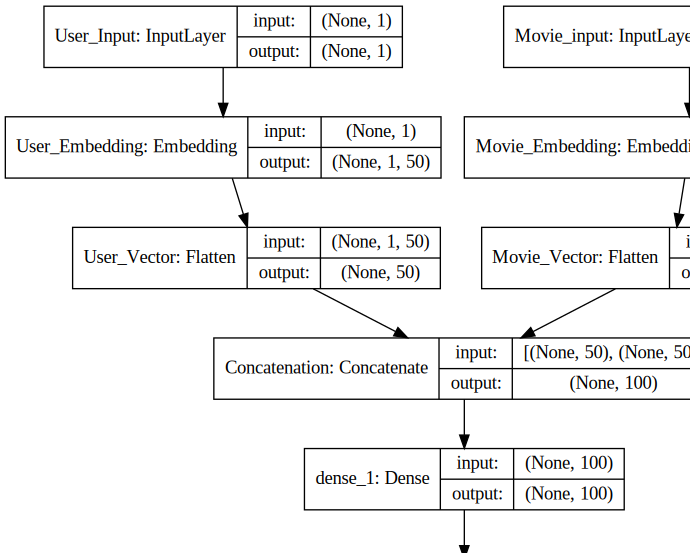

In [51]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [52]:
history = model.fit(x = [x_train[:,0] , x_train[:,1]] , y =y_train , batch_size = 128 , epochs = 30 , validation_data = ([x_test[:,0] , x_test[:,1]] , y_test))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 79992 samples, validate on 19999 samples
Epoch 1/30
79992/79992 [==============================] - 2s 30us/step - loss: 2.3144 - accuracy: 0.3041 - val_loss: 0.9444 - val_accuracy: 0.3847
Epoch 2/30
79992/79992 [==============================] - 2s 23us/step - loss: 1.1333 - accuracy: 0.3601 - val_loss: 0.9193 - val_accuracy: 0.3877
Epoch 3/30
79992/79992 [==============================] - 2s 23us/step - loss: 1.0998 - accuracy: 0.3656 - val_loss: 0.8983 - val_accuracy: 0.3998
Epoch 4/30
79992/79992 [==============================] - 2s 24us/step - loss: 1.0761 - accuracy: 0.3683 - val_loss: 0.8918 - val_accuracy: 0.3999
Epoch 5/30
79992/79992 [==============================] - 2s 24us/step - loss: 1.0544 - accuracy: 0.3762 - val_loss: 0.8850 - val_accuracy: 0.4017
Epoch 6/30
79992/79992 [==============================] - 2s 24us/step - loss: 1.0360 - accuracy: 0.3772 - val_loss: 0.8835 - val_accuracy: 0.4087
Epoch 7/30
79992/79992 [==============================] - 2s 25us/st

In [53]:
loss , val_loss , accuracy , val_accuracy = history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy']

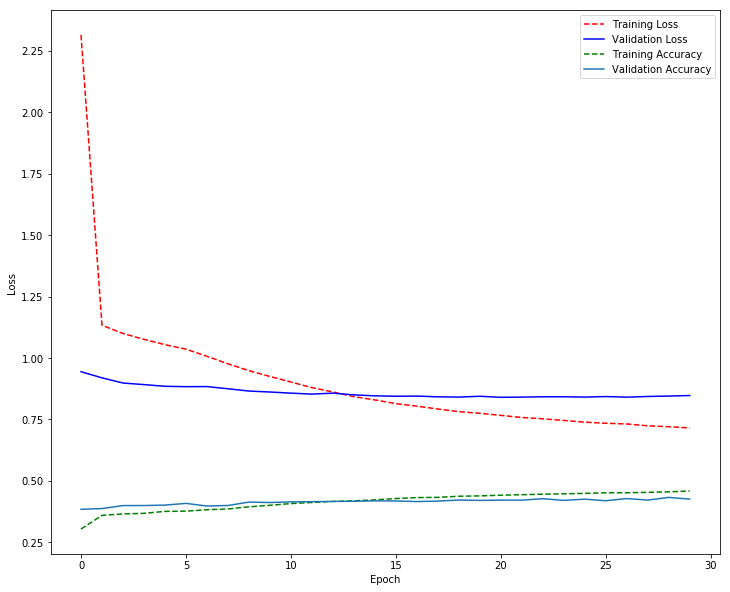

In [54]:
plt.figure(figsize = (12,10))
plt.plot( loss, 'r--')
plt.plot(val_loss, 'b-')
plt.plot( accuracy, 'g--')
plt.plot(val_accuracy,'-')
plt.legend(['Training Loss', 'Validation Loss' , 'Training Accuracy' , 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [55]:
score = model.evaluate([x_test[:,0], x_test[:,1]], y_test)
print(np.sqrt(score))

19999/19999 [==============================] - 1s 27us/step
[0.92061155 0.65277967]


# Recommendation_systems_paperlist 
## Survey paper
* Recommender systems survey [Knowledge-based systems 2013]
* Deep Learning based Recommender System: A Survey and New Perspectives [2017]
* A Survey on Session-based Recommender System [2019] [[__pdf__](https://arxiv.org/pdf/1902.04864.pdf)]

## Recommendation Systems with Social Information 
* SoRec: Social Recommendation Using Probabilistic Matrix Factorization [CIKM 2008]
* A Matrix Factorization Technique with Trust Propagation for Recommendation in Social Networks [RecSys 2010]
* Recommender systems with social regularization [WSDM 2011]
* On Deep Learning for Trust-Aware Recommendations in Social Networks [IEEE 2017]
* Learning to Rank with Trust and Distrust in Recommender Systems [RecSys 2017]
* Social Attentional Memory Network: Modeling Aspect- and Friend-level Differences in Recommendation [WSDM 2019]
    - code : https://github.com/chenchongthu/SAMN
* Session-based Social Recommendation via Dynamic Graph Attention Networks [WSDM 2019]
  - code : https://github.com/DeepGraphLearning/RecommenderSystems/tree/master/socialRec
* Dual Graph Attention Networks for Deep Latent Representation of Multifaceted Social Effects in Recommender Systems [WWW 2019]
* Heterogeneous Graph Attention Network [WWW 2019]
* Graph Neural Networks for Social Recommendation [WWW 2019]
* GhostLink: Latent Network Inference for Influence-aware Recommendation [WWW 2019]
* SamWalker: Social Recommendation with Informative Sampling Strategy [WWW 2019]
* Social Recommendation with Optimal Limited Attention [KDD 2019]

## Recommendation Systems with Text Information
  ### Topic-based approach
  * Collaborative topic modeling for recommending scientific articles [KDD 2011]
    - code : https://github.com/blei-lab/ctr
  * Hidden factors and hidden topics: understanding rating dimensions with review text [RecSys 2013]
    - code : https://github.com/lipiji/HFT
  * Jointly modeling aspects, ratings and sentiments for movie recommendation [KDD 2014]
    - code : https://github.com/nihalb/JMARS
  * Ratings meet reviews, a combined approach to recommend [RecSys 2014]
  * Exploring User-Specific Information in Music Retrieval [SIGIR 2018]
  * Aspect-Aware Latent Factor Model: Rating Prediction with Ratings and Reviews [WWW 2018]
    - code : https://github.com/hustlingchen/ALFM
  * Exploiting Ratings, Reviews and Relationships for Item Recommendations in Topic Based Social Networks [WWW 2019]
  
  ### Deep learning-based approach
  * Collaborative deep learning for recommender systems [KDD 2015]
    - code : https://github.com/js05212/CDL
  * Convolutional Matrix Factorization for Document Context-Aware Recommendation [RecSys 2016]
    - code : https://github.com/cartopy/ConvMF
  * Joint Deep Modeling of Users and Items Using Reviews for Recommendation [WSDM 2017]
    - code : https://github.com/chenchongthu/DeepCoNN
  * Transnets: Learning to transform for recommendation [RecSys 2017]
    - code : https://github.com/rosecatherinek/TransNets
  * Latent Cross: Making Use of Context in Recurrent Recommender Systems [WSDM 2018]
  * Coevolutionary Recommendation Model: Mutual Learning between Ratings and Reviews [WWW 2018]
  * Neural Attentional Rating Regression with Review-level Explanations [WWW 2018]
    - code : https://github.com/chenchongthu/NARRE
  * Learning Personalized Topical Compositions with Item Response Theory [WSDM 2019]
  * Uncovering Hidden Structure in Sequence Data via Threading Recurrent Models [WSDM 2019]
  * Gated Attentive-Autoencoder for Content-Aware Recommendation [WSDM 2019]
    - code : https://github.com/allenjack/GATE
  * DAML: Dual Attention Mutual Learning between Ratings and Reviews for Item Recommendation [KDD 2019]   
    
## Explainable Recommendation Systems
* Social Collaborative Viewpoint Regression with Explainable Recommendations [WSDM 2017]
* Explainable Recommendation via Multi-Task Learning in Opinionated Text Data [SIGIR 2018]
* TEM: Tree-enhanced Embedding Model for Explainable Recommendation [WWW 2018]

## Session-Based Recommendation Systems
### Markov-chain based approach
* Factorizing Personalized Markov Chains for Next-Basket Recommendation [WWW 2010]
* Where You Like to Go Next: Successive Point-of-Interest Recommendation [IJCAI 2013]
* Learning Hierarchical Representation Model for NextBasket Recommendation [SIGIR 2015]
* Fusing Similarity Models with Markov Chains for Sparse Sequential Recommendation [ICDM 2016]
* Translation-based Recommendation [RecSys 2017]
    - code : https://drive.google.com/file/d/0B9Ck8jw-TZUEVmdROWZKTy1fcEE/view
    
### RNN based approach
* Session-based Recommendations with Recurrent Neural Networks [ICLR 2016]
  - code : https://github.com/hidasib/GRU4Rec
* Neural Attentive Session-based Recommendation [CIKM 2017]
  - code : https://github.com/lijingsdu/sessionRec_NARM
* Personalizing Session-based Recommendations with Hierarchical Recurrent Neural Networks [RecSys 2017]
* When Recurrent Neural Networks meet the Neighborhood for Session-Based Recommendation [RecSys 2017]
* Modeling User Session and Intent with an Attention-based Encoder-Decoder Architecture [RecSys 2017]
* Learning from History and Present: Next-item Recommendation via Discriminatively Exploting Users Behaviors [KDD 2018]
* Recurrent Neural Networks with Top-k Gains for Session-based Recommendations [CIKM 2018]
* Hierarchical Context enabled Recurrent Neural Network for Recommendation. [AAAI 2019] 
* RepeatNet: A Repeat Aware Neural Recommendation Machine for Session-based Recommendation [AAAI 2019]
  - code : https://github.com/PengjieRen/RepeatNet
* Time is of the Essence: a Joint Hierarchical RNN and Point Process Model for Time and Item Predictions [WSDM 2019]
  - code : https://github.com/BjornarVass/Recsys
* Predicting Dynamic Embedding Trajectory in Temporal Interaction Networks [KDD 2019]
* AIR: Attentional Intention-Aware Recommender Systems [ICDE 2019]

### CNN based approach 
* 3D Convolutional Networks for Session-based Recommendation with Content Features [RecSys 2017]
* Personalized Top-N Sequential Recommendation via Convolutional Sequence Embedding [WSDM 2018]
  - code : https://github.com/graytowne/caser_pytorch [Pytorch]
  - code : https://github.com/graytowne/caser [Matlab]
* Hierarchical Temporal Convolutional Networks for Dynamic Recommender Systems [WWW 2019]
* A Simple Convolutional Generative Network for Next Item Recommendation [WSDM 2019]
  - code : https://github.com/graytowne/caser_pytorch
  
### Graph based approach
* Billion-scale Commodity Embedding for E-commerce Recommendation in Alibaba [KDD 2018]
* Graph Convolutional Neural Networks for Web-Scale Recommender Systems [KDD 2018]
* Session-based Recommendation with Graph Neural Networks [AAAI 2019]
  - code : https://github.com/CRIPAC-DIG/SR-GNN
* Session-based Social Recommendation via Dynamic Graph Attention Networks [WSDM 2019]
  - code : https://github.com/DeepGraphLearning/RecommenderSystems/tree/master/socialRec  
* Graph Contextualized Self-Attention Network for Session-based Recommendation [IJCAI 2019]

### Other approach
* Diversifying Personalized Recommendation with User-session Context [IJCAI 2017]
* Translation-based Factorization Machines for Sequential Recommendation [RecSys 2018]
* Attention-Based Transactional Context Embedding for Next-Item Recommendation [AAAI 2018]
* STAMP: Short-Term Attention/Memory Priority Model for Session-based Recommendation [KDD 2018]
  - code : https://github.com/uestcnlp/STAMP
* Self-Attentive Sequential Recommendation [ICDM 2018]
  - code : https://github.com/kang205/SASRec
* Taxonomy-aware Multi-hop Reasoning Networks for Sequential Recommendation [WSDM 2019]
  - code : https://github.com/RUCDM/TMRN
* Hierarchical Neural Variational Model for Personalized Sequential Recommendation [WWW 2019]
* BERT4Rec: Sequential Recommendation with Bidirectional Encoder Representations from Transformer [CIKM 2019]
* Hierarchical Gating Networks for Sequential Recommendation [KDD 2019]
* Online Purchase Prediction via Multi-Scale Modeling of Behavior Dynamics [KDD 2019]
* Streaming Session-based Recommendation [KDD 2019]
* Hierarchical Gating Networks for Sequential Recommendation [KDD 2019]
* Log2Intent: Towards Interpretable User Modeling via Recurrent Semantics Memory Unit [KDD 2019]

### News Recommendation
* Google news personalization: scalable online collaborative filtering [WWW 2007]
* Personalized News Recommendation Based on Click Behavior [IUI 2009]
* Personalized News Recommendation Using Twitter [IEEE 2013]
* Recommending Personalized News in Short User Sessions [RecSys 2017]
* Embedding-based News Recommendation for Millions of Users [KDD 2017]
* DKN: Deep Knowledge-Aware Network for News Recommendation [WWW 2018] 
* NPA: Neural News Recommendation with Personalized Attention [KDD 2019]

### Video Recommendation
* Video suggestion and discovery for youtube: taking random walks through the view graph [WWW 2008]
* The YouTube Video Recommendation System [RecSys 2010]
* Deep Neural Networks for YouTube Recommendations [RecSys 2016]
* Wide & Deep Learning for Recommender Systems [DLRS 2016]
* Content-based Related Video Recommendations [NIPS 2016]

### Music Recommendation
* Playlist prediction via metric embedding [KDD 2012]
* Deep content-based music recommendation [NIPS 2013]
* Improving Content-based and Hybrid Music Recommendation using Deep Learning [MM 2014]
* Content-aware collaborative music recommendation using pre-trained neural networks [ISMIR 2015] 

### Image Recommendation
* Pagerank for product image search [WWW 2008]
* Related Pins at Pinterest: The Evolution of a Real-World Recommender System [WWW 2017]
* Pixie: A System for Recommending 3+ Billion Items to 200+ Million Users in Real-Time [WWW 2018]

## Time-aware Recommendation (Temporal Dynamics)
* Time Weight Collaborative Filtering [CIKM 2005]
* Collaborative Filtering with Temporal Dynamics [KDD 2009]
* Opportunity Models for E-commerce Recommendation: Right Product, Right Time [SIGIR 2013] 
* Multi-rate deep learning for temporal recommendation [SIGIR 2016]
* Recurrent Recommender Networks [WSDM 2017]
* Recurrent Recommendation with Local Coherence [WSDM 2019]

## Multi-Armed Bandit
* A Contextual-Bandit Approach to Personalized News Article Recommendation [WWW 2010]
* A survey of online experiment design with the stochastic multi-armed bandit [2015] [[__pdf__](https://arxiv.org/pdf/1510.00757.pdf)]
* Collaborative filtering as a multi-armed bandit [NIPS 2015]
* Online Context-Aware Recommendation with Time Varying Multi-Arm Bandit [KDD 2016]
* Collaborative Filtering Bandits [SIGIR 2016]

## Out of Category
* Learning Multiple Similarities of Users and Items in Recommender Systems [ICDM 2017]
* Neural Collaborative Filtering [WWW 2017]
* MRNet-Product2Vec: A Multi-task Recurrent Neural Network for Product Embeddings [ECML-PKDD 2017]
* A Gradient-based Adaptive Learning Framework for Efficient Personal Recommendation [RecSys 2017]
* IRGAN: A Minimax Game for Unifying Generative and Discriminative Information Retrieval Models [SIGIR 2017]
  - code : https://github.com/geek-ai/irgan
* Collaborative Memory Network for Recommendation Systems [SIGIR 2018]
  - code : https://github.com/tebesu/CollaborativeMemoryNetwork
* Variational Autoencoders for Collaborative Filtering [WWW 2018]
* Latent Relational Metric Learning via Memory-based Attention for Collaborative Ranking [WWW 2018]
* Causal Embeddings for Recommendation [RecSys 2018] 
  - https://github.com/criteo-research/CausE
* Linked Variational AutoEncoders for Inferring Substitutable and Supplementary Items [WSDM 2019]
  - https://github.com/VRM1/WSDM19
* RecWalk: Nearly Uncoupled Random Walks for Top-N Recommendation [WSDM 2019]
  - https://github.com/nikolakopoulos/RecWalk

